In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#!wget https://s3.amazonaws.com/higherlogicdownload/AMSTAT/UploadedImages/LanMM957S06KqifB8Sj9_temp.jpg

Here's a plot released last May by the white house "Council of Economic Advisers".

In [2]:
from IPython.display import Image
Image(filename='imgs/LanMM957S06KqifB8Sj9_temp.jpg') 

FileNotFoundError: [Errno 2] No such file or directory: 'imgs/LanMM957S06KqifB8Sj9_temp.jpg'

The black line shows data (COVID 19 deaths per day in the United States), the blue, yellow, and green curves show predictions from an epidemiological model, and the red curve shows a "cubic fit", with a future prediction in pink dots.

Some words about the model can be found here:
https://www.washingtonpost.com/health/government-report-predicts-covid-19-cases-will-reach-200000-a-day-by-june-1/2020/05/04/02fe743e-8e27-11ea-a9c0-73b93422d691_story.html

"White House officials have been relying on other models to make decisions on reopening, including the IHME model and a 'cubic model' prepared by Trump adviser and economist Kevin Hassett and the Council of Economic Advisers.

....

Even more optimistic than that, however, is the “cubic model” prepared by Trump adviser and economist Kevin Hassett. People with knowledge of that model say it shows deaths dropping precipitously in May — and essentially going to zero by May 15."


Today, we'll discuss (a) how to fit these kind of models, and (b) equally important, what the pitfalls of fitting them are. First, let's retrieve the raw data. 

In [3]:
#!wget https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv
lines = open('imgs/us.csv').readlines()
lines[:5]

FileNotFoundError: [Errno 2] No such file or directory: 'imgs/us.csv'

In [4]:
from astropy.time import Time
dates, cases, deaths = [], [], []
for line in lines[1:]:
    dates.append(Time(line.split(',')[0]))
    cases.append(int(line.split(',')[1]))
    deaths.append(int(line.split(',')[2]))
dates, cases, deaths = np.array(dates), np.array(cases), np.array(deaths)
year = np.array([x.byear for x in dates])

Text(0, 0.5, 'deaths (thousands)')

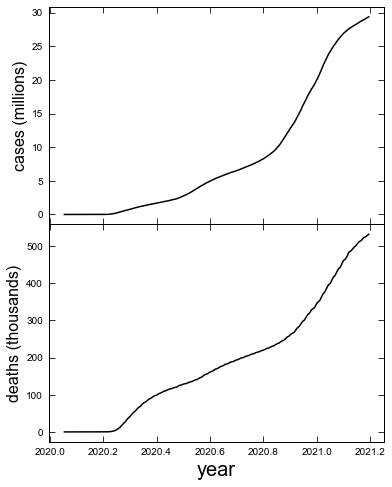

In [5]:
f, ax = plt.subplots(2, 1, figsize=(6, 8))
plt.subplots_adjust(hspace=0)
ax[0].set_xticklabels([])
ax[0].plot(year, cases/1e6, 'k')
ax[1].plot(year, deaths/1e3, 'k')
ax[1].set_xlabel('year', fontsize=20)
ax[0].set_ylabel('cases (millions)', fontsize=16)
ax[1].set_ylabel('deaths (thousands)', fontsize=16)

Text(0, 0.5, 'new deaths (thousands)')

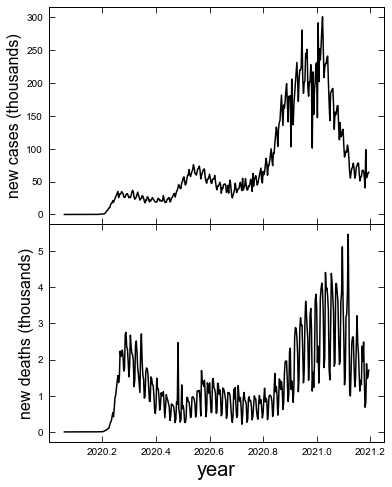

In [6]:
# above data is cumulative; let's plot new cases/deaths per day. 
new_cases = np.diff(cases)
new_deaths = np.diff(deaths)
year_ = year[1:]

f, ax = plt.subplots(2, 1, figsize=(6, 8))
plt.subplots_adjust(hspace=0)
ax[0].set_xticklabels([])
ax[0].plot(year_, new_cases/1e3, 'k')
ax[1].plot(year_, new_deaths/1e3, 'k')
ax[1].set_xlabel('year', fontsize=20)
ax[0].set_ylabel('new cases (thousands)', fontsize=16)
ax[1].set_ylabel('new deaths (thousands)', fontsize=16)

Text(0, 0.5, 'new deaths (thousands)')

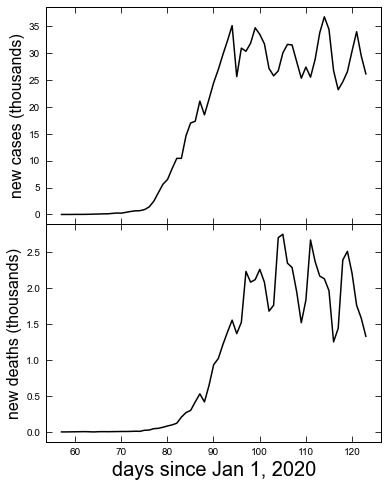

In [7]:
# let's only consider data between Feb 26 and May 5, 2020, to match the CEA plot. 
msk = (year_ < Time('2020-05-04').byear) & (year_ > Time('2020-02-26').byear)

new_cases_may5 = new_cases[msk]
new_deaths_may5 = new_deaths[msk]
year_may5 = year_[msk]
days_into_2020 = (year_may5-2020)*365

f, ax = plt.subplots(2, 1, figsize=(6, 8))
plt.subplots_adjust(hspace=0)
ax[0].set_xticklabels([])
ax[0].plot(days_into_2020, new_cases_may5/1e3, 'k')
ax[1].plot(days_into_2020, new_deaths_may5/1e3, 'k')
ax[1].set_xlabel('days since Jan 1, 2020', fontsize=20)
ax[0].set_ylabel('new cases (thousands)', fontsize=16)
ax[1].set_ylabel('new deaths (thousands)', fontsize=16)

Text(0, 0.5, 'y')

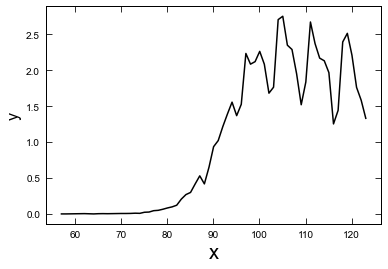

In [8]:
# let's turn this into a generic dataset of dimensionless y vs x. 
x, y = days_into_2020, new_deaths_may5/1e3

f = plt.figure()
ax = f.add_subplot(111)
ax.plot(x, y, 'k')
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=16)


'Cubic' model says:

$$\begin{align} y_{1}&=p_{0}+p_{1}x_{1}+p_{2}x_{1}^{2}+p_{3}x_{1}^{3}\\y_{2}&=p_{0}+p_{1}x_{2}+p_{2}x_{2}^{2}+p_{3}x_{2}^{3}\\y_{3}&=\cdots
\end{align}$$

We can write this as a matrix equation:
$$\vec{y}={\bf X}\vec{p}$$

Where $$ {\bf X}=\left(\begin{array}{cccc}
1 & x_{1} & x_{1}^{2} & x_{1}^{3}\\
1 & x_{2} & x_{2}^{2} & x_{2}^{3}\\
 & \cdots
\end{array}\right)$$

In [9]:
def make_X_matrix(x_vec, polyorder = 3):
    '''x_vec = (x1, x2, ....)'''
    X = [np.ones(len(x_vec))]
    for i in range(1, polyorder+1):
        X.append(np.power(x_vec, i))
    return np.array(X).T

In [10]:
make_X_matrix(x[:5], 3)

array([[1.00000000e+00, 5.70847472e+01, 3.25866837e+03, 1.86020260e+05],
       [1.00000000e+00, 5.80840841e+01, 3.37376083e+03, 1.95961808e+05],
       [1.00000000e+00, 5.90834210e+01, 3.49085064e+03, 2.06251398e+05],
       [1.00000000e+00, 6.00827579e+01, 3.60993779e+03, 2.16895018e+05],
       [1.00000000e+00, 6.10820947e+01, 3.73102230e+03, 2.27898658e+05]])

In [11]:
# solve the matrix equation. 
def get_coeffs(x_vec, y_vec, polyorder = 3):
    '''
    set up the X matrix, then solve it. 
    '''
    X = make_X_matrix(x_vec, polyorder = polyorder)
    coeffs, resid, _, _ = np.linalg.lstsq(X, y_vec, rcond=-1)
    return coeffs

In [12]:
coeffs_cubic = get_coeffs(x, y, 3)
coeffs_cubic

array([ 3.86969714e+01, -1.43586031e+00,  1.70037253e-02, -6.33123014e-05])

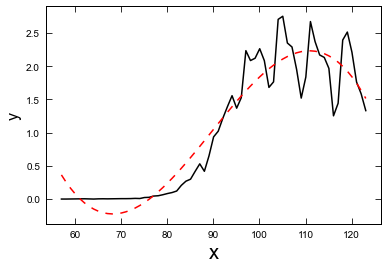

In [13]:
# plot it. 
f = plt.figure()
ax = f.add_subplot(111)
ax.plot(x, y, 'k')
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=16)

y_pred_cubic = np.poly1d(coeffs_cubic[::-1])(x)
plt.plot(x, y_pred_cubic, 'r--')

# looks like a reasonable fit, but not identical to the CEA plot.

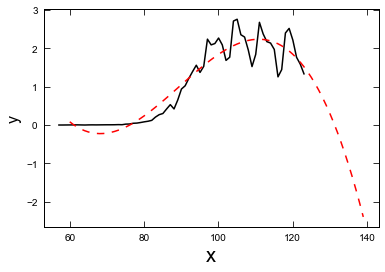

In [14]:
# let's extrapolate a little farther

f = plt.figure()
ax = f.add_subplot(111)
ax.plot(x, y, 'k')
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=16)

x_grid = np.arange(60, 140)
y_pred_cubic = np.poly1d(coeffs_cubic[::-1])(x_grid)
ax.plot(x_grid, y_pred_cubic, 'r--')


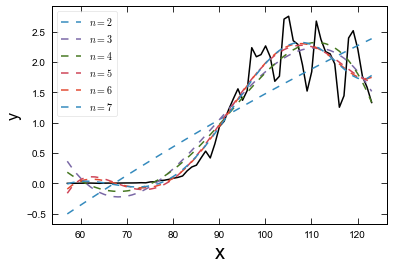

In [15]:
# why stop at a cubic?

f = plt.figure()
ax = f.add_subplot(111)
ax.plot(x, y, 'k')
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=16)

poly_orders = np.arange(2, 8)

for porder in poly_orders:
    coeffs =  get_coeffs(x, y, porder)
    y_pred = np.poly1d(coeffs[::-1])(x)
    ax.plot(x, y_pred, '--', label = r'$n = %d$' % porder)
ax.legend(loc = 'upper left')

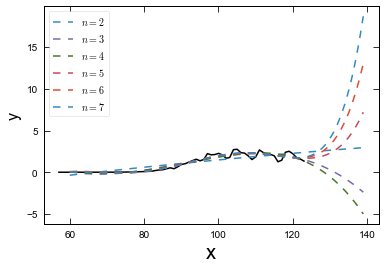

In [16]:
# extrapolating forward
f = plt.figure()
ax = f.add_subplot(111)
ax.plot(x, y, 'k')
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=16)

poly_orders = np.arange(2, 8)
x_grid = np.arange(60, 140)

for porder in poly_orders:
    coeffs =  get_coeffs(x, y, porder)
    y_pred = np.poly1d(coeffs[::-1])(x_grid)
    ax.plot(x_grid, y_pred, '--', label = r'$n = %d$' % porder)
ax.legend(loc = 'upper left')

In [17]:
get_coeffs(x, y, 3)

array([ 3.86969714e+01, -1.43586031e+00,  1.70037253e-02, -6.33123014e-05])

In [18]:
# turns out numpy gives us a function to do all this in one line. 

np.polyfit(x, y, 3)[::-1]

array([ 3.86969714e+01, -1.43586031e+00,  1.70037253e-02, -6.33123014e-05])

What's the difference between extrapolation and interpolation?

In [19]:
# We can also fit a polynomial using curve_fit, a nonlinear optimizer
from scipy.optimize import curve_fit

def polynomial(x_vec, *p_vec):
    #print(p_vec)
    return np.sum( np.array([p*x_vec**(i) for i, p in enumerate(p_vec)]), axis=0 )


popt, pcov = curve_fit(polynomial, x, y, p0 = [0, 0, 0, 0])
popt

array([ 3.86969648e+01, -1.43586008e+00,  1.70037226e-02, -6.33122918e-05])

In [20]:
# under the hood, curve_fit is minimizing the sum-of-squared residuals. We can do that directly, too. 
from scipy.optimize import leastsq


def residuals(p_vec, x_vec, y_vec):
    y_pred = polynomial(x_vec, *p_vec)
    print(p_vec, np.sum((y_pred - y_vec)**2))
    return y_pred - y_vec

res, _ = leastsq(residuals, x0=[0, 0,0,0], args=(x, y))
res

[0 0 0 0] 131.471586
[0. 0. 0. 0.] 131.471586
[0. 0. 0. 0.] 131.471586
[1.49011612e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00] 131.47158397892574
[0.00000000e+00 1.49011612e-08 0.00000000e+00 0.00000000e+00] 131.4713713429503
[0.00000000e+00 0.00000000e+00 1.49011612e-08 0.00000000e+00] 131.44858350710592
[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.49011612e-08] 128.99924512367537
[-7.33153132e-01 -4.97978655e-02  1.24946017e-03 -5.25728760e-06] 13.501615136293019
[-7.33153121e-01 -4.97978655e-02  1.24946017e-03 -5.25728760e-06] 13.501615136339677
[-7.33153132e-01 -4.97978648e-02  1.24946017e-03 -5.25728760e-06] 13.501615138119508
[-7.33153132e-01 -4.97978655e-02  1.24946019e-03 -5.25728760e-06] 13.501615124883296
[-7.33153132e-01 -4.97978655e-02  1.24946017e-03 -5.25728752e-06] 13.5016151385316
[ 4.34658201e+00 -2.29968882e-01  3.31484267e-03 -1.29277186e-05] 11.72172429519519
[ 4.34658207e+00 -2.29968882e-01  3.31484267e-03 -1.29277186e-05] 11.721724294434173
[ 4.34658201e+

array([ 3.86969648e+01, -1.43586008e+00,  1.70037226e-02, -6.33122918e-05])

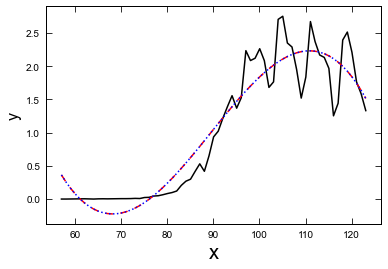

In [21]:
# the two methods should give the same best-fit. 

f = plt.figure()
ax = f.add_subplot(111)
ax.plot(x, y, 'k')
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=16)

y_pred_cubic = np.poly1d(coeffs_cubic[::-1])(x)
y_pred_cubic_minimize = np.poly1d(res[::-1])(x)
plt.plot(x, y_pred_cubic, 'r--')
plt.plot(x, y_pred_cubic_minimize, 'b:')

In [22]:
##### try mcmc ####
import pymc3 as pm
import theano
import theano.tensor as tt

model = pm.Model()

# set the priors based on the maximum likelihood fit (otherwise the sampler will struggle) 
with model:
    p0 = pm.Normal('p0', mu = coeffs_cubic[0], sigma = 10)
    p1 = pm.Normal('p1', mu = coeffs_cubic[1], sigma = 1)
    p2 = pm.Normal('p2', mu = coeffs_cubic[2], sigma = 0.1)
    p3 = pm.Normal('p3', mu = coeffs_cubic[3], sigma = 0.01)
    lns = pm.Uniform('lns', lower = -1.5, upper = -0.7)
    
    
    yhat = pm.Normal('yhat', mu = p0 + p1*x + p2*x**2 + p3*x**3, sd = tt.exp(lns), observed = y)
    
with model:
    step = pm.NUTS()
    trace = pm.sample(5000, step=step)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lns, p3, p2, p1, p0]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 461 seconds.
There were 868 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.899065604007009, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 1133 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 263 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 10% for

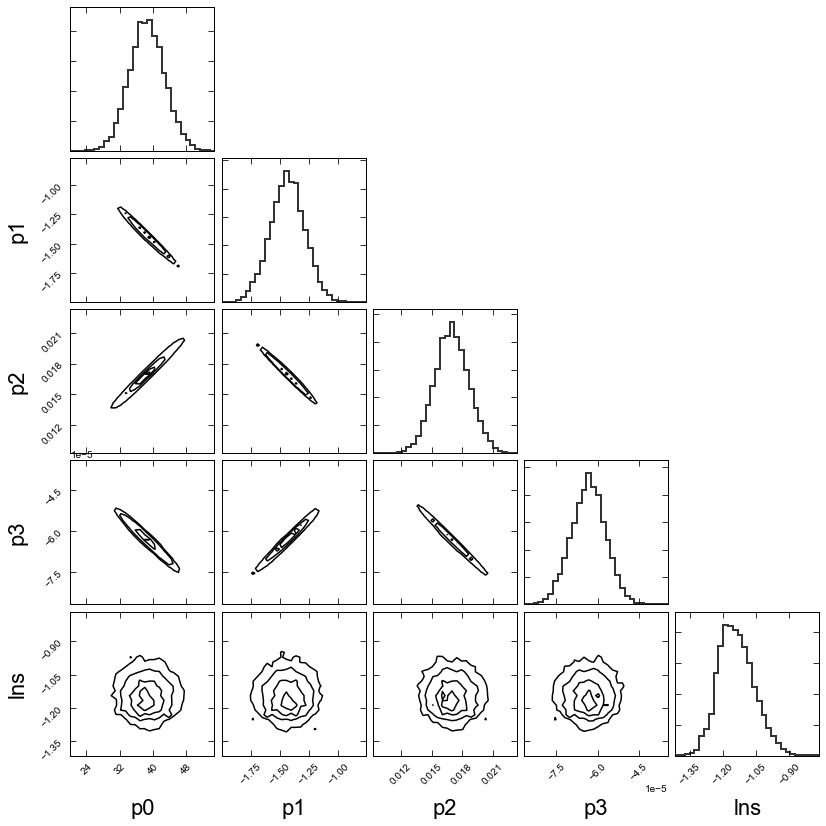

In [23]:
import corner
samples = np.vstack((trace['p0'], trace['p1'],trace['p2'], trace['p3'], trace['lns'])).T

_ = corner.corner(samples,  labels = ['p0', 'p1', 'p2', 'p3', 'lns'], 
        label_kwargs = {'fontsize': 22},  plot_datapoints = False, 
        plot_density = False, color = 'k', bins = 30, hist_kwargs = {'lw': 2, 'alpha' : 0.8})

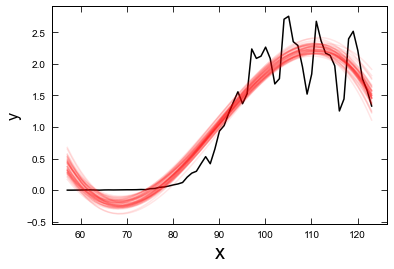

In [24]:
# visualize these fits

f = plt.figure()
ax = f.add_subplot(111)
ax.plot(x, y, 'k')
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=16)

Nsamples = 50
randints = np.random.randint(0, len(samples), Nsamples)
for i in range(Nsamples):
    these_coeffs = samples[i][:-1]
    this_ypred = np.poly1d(these_coeffs[::-1])(x)
    ax.plot(x, this_ypred, 'r', alpha=0.1)



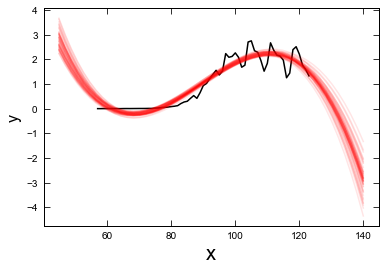

In [25]:
# extrapolate a bit

f = plt.figure()
ax = f.add_subplot(111)
ax.plot(x, y, 'k')
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=16)

Nsamples = 50
randints = np.random.randint(0, len(samples), Nsamples)
x_grid = np.linspace(45, 140)
for i in range(Nsamples):
    these_coeffs = samples[i][:-1]
    this_ypred = np.poly1d(these_coeffs[::-1])(x_grid)
    ax.plot(x_grid, this_ypred, 'r', alpha=0.1)



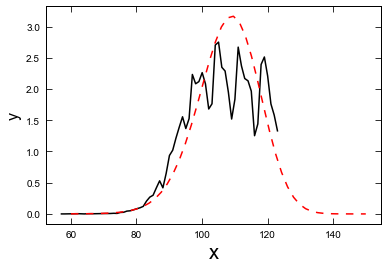

In [26]:
# what if we fit a cubic to the log data (what the CEA probably did)?

f = plt.figure()
ax = f.add_subplot(111)
ax.plot(x, y, 'k')
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=16)

log_coeffs = get_coeffs(x[np.isfinite(np.log(y))], np.log(y[np.isfinite(np.log(y))]), 3)

x_grid = np.linspace(60, 150)
y_pred_cubic = np.exp(np.poly1d(log_coeffs[::-1])(x_grid))
plt.plot(x_grid, y_pred_cubic, 'r--')


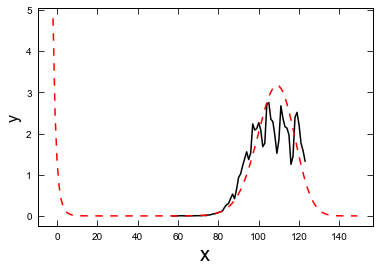

In [27]:
# I wonder what this model predicts in the past?
f = plt.figure()
ax = f.add_subplot(111)
ax.plot(x, y, 'k')
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=16)

log_coeffs = get_coeffs(x[np.isfinite(np.log(y))], np.log(y[np.isfinite(np.log(y))]), 3)

x_grid = np.arange(-2, 150)
y_pred_cubic = np.exp(np.poly1d(log_coeffs[::-1])(x_grid))
plt.plot(x_grid, y_pred_cubic, 'r--')


Text(0, 0.5, 'y')

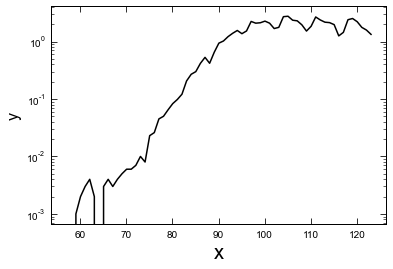

In [28]:
# what if we want to fit some other function? Say, an exponential?
f = plt.figure()
ax = f.add_subplot(111)
ax.semilogy(x, y, 'k')
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=16)


Text(0, 0.5, 'y')

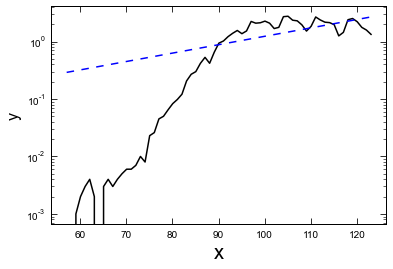

In [29]:
def exp_function(x_vec, tau, x0):
    return np.exp((x_vec-x0)/tau)

popt, pcov = curve_fit(exp_function, x, y, p0 = [90, 1 ])


f = plt.figure()
ax = f.add_subplot(111)
ax.semilogy(x, y, 'k')
ax.semilogy(x, exp_function(x, popt[0], popt[1]), 'b--')
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=16)

# doesn't look very good, because the exoponential flattens. 

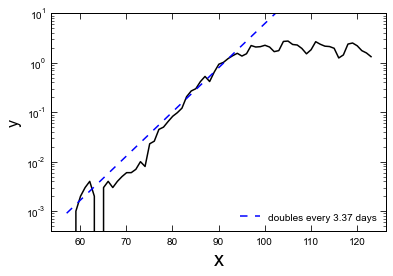

In [30]:
#what if we exclude the part where it flattened off?

msk_exp = x < 90
popt, pcov = curve_fit(exp_function, x[msk_exp], y[msk_exp], p0 = [90, 1])


f = plt.figure()
ax = f.add_subplot(111)
ax.semilogy(x, y, 'k')
ax.semilogy(x, exp_function(x, popt[0], popt[1],), 'b--',label = f'doubles every %.2f days' % (popt[0]*np.log(2)) ) 
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=16)
ax.set_ylim(4e-4, 10)
ax.legend(loc= 'lower right', frameon = False)

Text(0.5, 1.0, 'any fool can fit models')

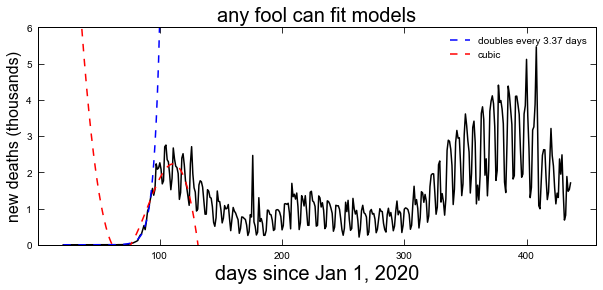

In [31]:
x_full = (year_ - 2020)*365
y_pred_cubic_full = np.poly1d(coeffs_cubic[::-1])(x_full)

f = plt.figure(figsize=(10,4))
ax = f.add_subplot(111)
ax.plot(x_full, new_deaths/1e3, 'k')
ax.plot(x_full, exp_function(x_full, popt[0], popt[1],), 'b--',label = f'doubles every %.2f days' % (popt[0]*np.log(2)) ) 
plt.plot(x_full, y_pred_cubic_full, 'r--', label = 'cubic')
ax.set_xlabel('days since Jan 1, 2020', fontsize=20)
ax.set_ylabel('new deaths (thousands)', fontsize=16)
ax.set_ylim(4e-4, 10)
ax.set_ylim(0, 6)
ax.legend(loc= 'upper right', frameon = False)
ax.set_title('any fool can fit models', fontsize=20)


Just because any fool can, doens't mean any fool should: imagine looking at that red line last May, and saying "great, this will all be over in two weeks!"

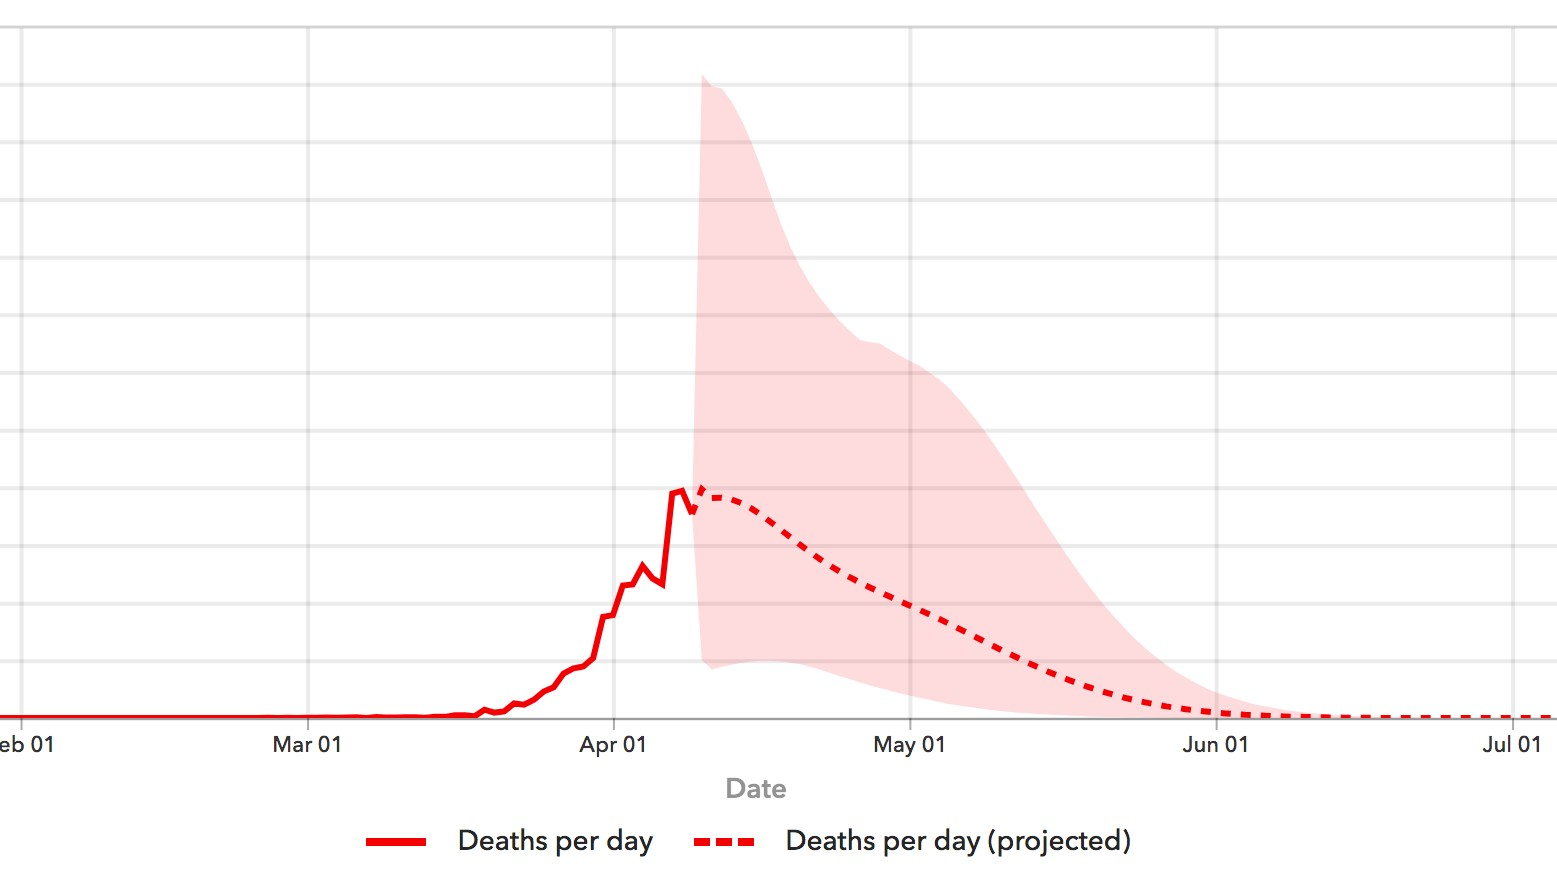

In [32]:
# what's wrong with this picture?

Image(filename='imgs/IHME.jpg') 

Some other takeaways:
- Polynomials are often used as fitting functions if one doesn't have a good "physical" model. They are often OK for interpolation, but very bad for extrapolation.
- Physically motivated models are often more useful than "flexible" fitting functions.
- It's easy to dress up a model in all kinds of sophisticated looking nonsense. Sophisticated looking nonsense is no substitute for a good model. Garbage in, garbage out.
- When you predict the future (or other soon-to-be explored region of parameter space), it's very easy to be proven wrong. 
- You might think the incentive structures that lead to models like the "cubic" model exist in politics, but not in science. Nope! 
- See in particular: earthquake prediction, long-range weather forecasting, mathematical modeling of the stock market, ...